In [1]:
import torch.nn as nn
import torch
    
class default_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(default_layer, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,1,1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.seq(x)  
    
class up_layer(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(up_layer,self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.layer = default_layer(in_channels, out_channels)
        
    def forward(self,x):
        return self.layer(self.upsample(x))

class recurrent_layer(nn.Module):
    def __init__(self, channels):
        super(recurrent_layer, self).__init__()
        self.layer = default_layer(channels, channels)

    def forward(self, x):
        return self.layer(x + self.layer(x))  
    
class recurrent_block(nn.Module):
    def __init__(self,  in_channels, out_channels):
        super(recurrent_block, self).__init__()
        self.r2c = nn.Sequential(
            recurrent_layer(out_channels),
            recurrent_layer(out_channels)
        )
        self.conv1x1 = nn.Conv2d(in_channels,out_channels,1)
        
    def forward(self, x):
        x = self.conv1x1(x)
        return x + self.r2c(x)
    
class down_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(down_block, self).__init__()
        self.r2c = recurrent_block(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = self.r2c(x)
        return self.maxpool(x), x
    
class up_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(up_block, self).__init__()
        self.in_channels = in_channels
        self.up_layer = up_layer(in_channels, out_channels)
        self.r2c = recurrent_block(in_channels,out_channels)

    def forward(self, x, attachment):
        x = self.up_layer(x)
        
        x = torch.cat((attachment,x),dim=1)
        x = self.r2c( x)
        
        return x
    
class Segnet(nn.Module):
    def __init__(self, classes):
        super(Segnet, self).__init__()
        
        self.down_rcl1 = down_block(3, 64)
        self.down_rcl2 = down_block(64, 128)
        self.down_rcl3 = down_block(128, 256)
        self.down_rcl4 = down_block(256, 512)
        
        self.down_rcl5 = recurrent_block(512, 1024)
        
        self.up_rcl1 = up_block(1024, 512)
        self.up_rcl2 = up_block(512, 256)
        self.up_rcl3 = up_block(256, 128)
        self.up_rcl4 = up_block(128, 64)
        self.conv1x1 = nn.Conv2d(64,classes,1)

    def forward(self, x):
        x, a = self.down_rcl1(x)
        x, b = self.down_rcl2(x)
        x, c = self.down_rcl3(x)
        x, d = self.down_rcl4(x)
        x = self.down_rcl5(x)
        
        x = self.up_rcl1(x, d)
        x = self.up_rcl2(x, c)
        x = self.up_rcl3(x, b)
        x = self.up_rcl4(x, a)
        x = self.conv1x1(x)
        
        return x

In [2]:
'''import os
from PIL import Image

def removesuffix(content, suffix):
    if content.endswith(suffix):
        content = content[:-len(suffix)]
    return content

def findFiles(rootDir, suffix):
    files = []
    for r, d, f in os.walk(rootDir):
        for file in f:
            if suffix in file:
                files.append(removesuffix(str(file), suffix))
    return files

def substringBefore(string, char):
    return string[:string.index(char)]

dataset = "val"

inputRoot = "/datasets/leftImg8bit/" + dataset + "/"
targetRoot = "/datasets/gtFine/" + dataset + "/"
inputSuffix = '_leftImg8bit.png'
targetSuffix = '_gtFine_labelIds.png'

reducedRoot = "/datasets/cityscapes/medium/" + dataset + "/"


os.makedirs(reducedRoot + "input/" )
os.makedirs(reducedRoot + "target/" )

files = findFiles(inputRoot, inputSuffix)
#targetImages = findFiles(inputRoot, targetSuffix)

i = 0;

targetSize = (512, 256)

for file in files:
    
    
    cityName = substringBefore(file, "_")
    
    input = Image.open(inputRoot + cityName + "/" + file + inputSuffix)
    target = Image.open(targetRoot + cityName + "/" + file + targetSuffix)

    input = input.resize(targetSize)
    target = target.resize(targetSize, Image.NEAREST)

    input.save(reducedRoot + "input/" + str(i).zfill(4) +  ".png")
    target.save(reducedRoot + "target/" + str(i).zfill(4) +  ".png")
    
    i += 1

'''

'import os\nfrom PIL import Image\n\ndef removesuffix(content, suffix):\n    if content.endswith(suffix):\n        content = content[:-len(suffix)]\n    return content\n\ndef findFiles(rootDir, suffix):\n    files = []\n    for r, d, f in os.walk(rootDir):\n        for file in f:\n            if suffix in file:\n                files.append(removesuffix(str(file), suffix))\n    return files\n\ndef substringBefore(string, char):\n    return string[:string.index(char)]\n\ndataset = "val"\n\ninputRoot = "/datasets/leftImg8bit/" + dataset + "/"\ntargetRoot = "/datasets/gtFine/" + dataset + "/"\ninputSuffix = \'_leftImg8bit.png\'\ntargetSuffix = \'_gtFine_labelIds.png\'\n\nreducedRoot = "/datasets/cityscapes/medium/" + dataset + "/"\n\n\nos.makedirs(reducedRoot + "input/" )\nos.makedirs(reducedRoot + "target/" )\n\nfiles = findFiles(inputRoot, inputSuffix)\n#targetImages = findFiles(inputRoot, targetSuffix)\n\ni = 0;\n\ntargetSize = (512, 256)\n\nfor file in files:\n    \n    \n    cityName

In [3]:
import torch.nn as nn
import torch

device = torch.device("cuda:7")
model = torch.load("/datasets/fullModels/r2u_epoch_182.model", map_location=device)


In [4]:
from torch.utils import data
import os
import numpy as np
from PIL import Image
from torchvision import transforms

root = "/datasets/cityscapes/medium/val/"


mapping = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
#mapping = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]


class cityscapes(data.Dataset):
    def __init__(self):
        self.tf = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
        pass
    def __len__(self):
        return 500
    def __getitem__(self, index):
        name = str(index).zfill(4) + ".png"
        input = Image.open(root + "input/" + name )
        target = Image.open(root + "target/" + name )
        
        inputTensor = self.tf(input)
        
        targetTensor = torch.from_numpy(np.array(target)).int()
        
        #targetResultTensor = torch.zeros((len(mapping), 256, 512), dtype=torch.float32)
        
        masks = []

        for i in mapping:
            masks.append(targetTensor == i)
        
        return inputTensor, torch.stack(masks).float()

dst = cityscapes()
trainloader = data.DataLoader(dst, batch_size = 1, num_workers = 10)

tensor([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 13, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 26, 29])
----- tensor(9305)
tensor(0.8367)
torch.Size([1, 30, 256, 512]) torch.Size([1, 30, 256, 512])


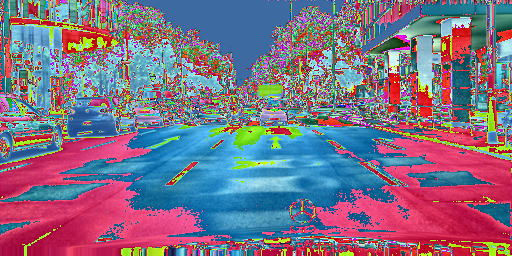

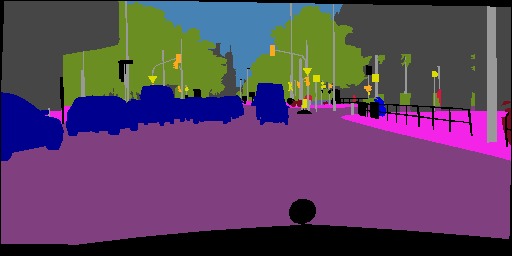

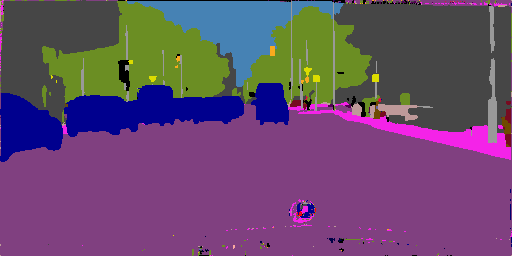

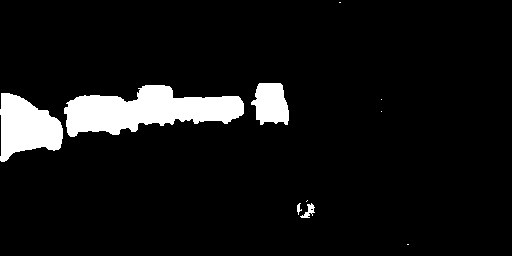

In [163]:
from IPython.display import clear_output

colors = torch.tensor([
    [  0,  0,  0],
    [111, 74,  0],
    [ 81,  0, 81],
    [128, 64,128],
    [244, 35,232],
    [250,170,160],
    [230,150,140],
    [ 70, 70, 70],
    [102,102,156],
    [190,153,153],
    [180,165,180],
    [150,100,100],
    [150,120, 90],
    [153,153,153],
    [153,153,153],
    [250,170, 30],
    [220,220,  0],
    [107,142, 35],
    [152,251,152],
    [ 70,130,180],
    [220, 20, 60],
    [255,  0,  0],
    [  0,  0,142],
    [  0,  0, 70],
    [  0, 60,100],
    [  0,  0, 90],
    [  0,  0,110],
    [  0, 80,100],
    [  0,  0,230],
    [119, 11, 32],
    [  0,  0,  0]
]) / 255


from time import sleep

model.train()
with torch.no_grad():
    for i, (inputs, targets) in enumerate(trainloader):
        #if loss != None and i % 50 == 0:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        outputs = outputs.cpu()
        targets = targets.cpu()


        targetValues, targetIndices = targets.max(dim=1)
        values, indices = outputs.max(dim=1)

        #targetIndices[targetValues < 0.1] = 30
        #indices[values < 0.1] = 30
        
        colorImage = torch.stack([colors[indices, 0 ], colors[indices, 1], colors[indices, 2]], dim=1)
        targetImage = torch.stack([colors[targetIndices, 0 ], colors[targetIndices, 1], colors[targetIndices, 2]], dim=1)

        clear_output(wait=False)
        
        
        print(indices.unique())

        print("-----", torch.sum(torch.logical_and((targetIndices == 22), (indices == 22)))  )
        print((targetIndices == indices).float().sum() / torch.prod(torch.tensor(list(targetIndices.size()))))
        print(outputs.shape, targets.shape)
        display(transforms.ToPILImage()( inputs[0] ))
        display(transforms.ToPILImage()( targetImage[0] ))
        display(transforms.ToPILImage()( colorImage[0] ))
        display(transforms.ToPILImage()( (indices == 22).float() ))
        sleep(5)
        break


In [199]:

import sklearn.metrics
precision = 0
recall = 0
jaccard = 0
dice = 0
count = 0
result = 0
test = 0

tnrs = np.zeros(30)
accs = np.zeros(30)

precisions = np.zeros(30)
precisions_counter = np.zeros(30)


dice = np.zeros(30)
dice_count = np.zeros(30)
jaccard = np.zeros(30)
jaccard_count = np.zeros(30)
confusion_matrix = np.zeros((30, 30))

model.train()
with torch.no_grad():
    for i, (inputs, targets) in enumerate(trainloader):
        if i % 100 == 0:
            print(i)
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)

        outputs = outputs.cpu()
        targets = targets.cpu()


        targetValues, targetIndices = targets.max(dim=1)
        values, indices = outputs.max(dim=1)

        #targetIndices[targetValues < 0.1] = 30
        #indices[values < 0.1] = 30
        
        #result += (targetIndices == indices).float().sum() / torch.prod(torch.tensor(list(targetIndices.size())))
        
        flattenTarget = targetIndices.flatten()
        flattenOutput = indices.flatten()
        
        #precision += sklearn.metrics.precision_score(flattenTarget, flattenOutput, average='micro')
        #recall += sklearn.metrics.recall_score(flattenTarget, flattenOutput, average='micro')
        #jaccard += sklearn.metrics.jaccard_score(flattenTarget, flattenOutput, average='micro')
        
        confusion_matrix += sklearn.metrics.confusion_matrix(flattenTarget, flattenOutput, labels=range(30))
        
        #result += torch.sum(torch.diag(conf_matrix)) / torch.sum(conf_matrix)
        
        for k in range(30):
            targetIsK = flattenTarget==k
            outputIsK = flattenOutput==k
            occured = (torch.sum(outputIsK) + torch.sum(targetIsK))
            if occured != 0:
                dice_count[k] += 1
                dice[k] += torch.sum(flattenOutput[targetIsK]==k)*2.0 / occured
                
            denominator = torch.sum(torch.logical_or(targetIsK, outputIsK))
            
            if denominator != 0:
                jaccard_count[k] += 1
                jaccard[k] += torch.sum(torch.logical_and(targetIsK, outputIsK)) / denominator
         
        
      
        '''
        dice_tmp = 0
        temp_counter = 0
        for k in mapping:
            occured = (torch.sum(flattenOutput==k) + torch.sum(flattenTarget==k))
            if occured > 0:
                temp_counter += 1
                dice_tmp += torch.sum(flattenOutput[flattenTarget==k]==k)*2.0 / occured
        dice += dice_tmp / temp_counter
        
        
        
        test_tmp = 0
        temp_counter = 0
        for k in mapping:
            targetIsK = flattenTarget==k
            outputIsK = flattenOutput==k
            uuu = torch.sum(torch.logical_or(targetIsK, outputIsK))
            if uuu > 0:
                temp_counter += 1
                test_tmp += torch.sum(torch.logical_and(targetIsK, outputIsK)) / uuu
        test += test_tmp / temp_counter
        '''
dice /= dice_count 
jaccard /= jaccard_count  



0
100
200
300
400


[500. 496. 487. 500. 500. 443.  89. 500. 419. 500.   2. 175. 141. 500.
 272. 500. 492. 500. 416. 499. 476. 498. 500. 427. 233. 203. 500. 385.
 418. 467.]


In [201]:
from IPython.display import HTML, display
import tabulate

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

SE = np.nan_to_num(TP/(TP+FN))
SP = TN/(TN+FP) 
ACC = (TP+TN)/(TP+FP+FN+TN)


names = [
    "static",
    "dynamic",
    "ground",
    "road",
    "sidewalk",
    "parking",
    "rail track",
    "building",
    "wall",
    "fence",
    "guard rail",
    "bridge",
    "tunnel",
    "pole",
    "polegroup",
    "traffic light",
    "traffic sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "caravan",
    "trailer",
    "train",
    "motorcycle",
    "bicycle"
]

    
def plot(table):
    display(HTML(tabulate.tabulate(torch.tensor(table), tablefmt='html')))
    
import pandas as pd



frame = [np.append(names, "**Average"), 
         np.append(SE, np.sum(SE) / 30), 
         np.append(SP, np.sum(SP) / 30), 
         np.append(ACC, np.sum(ACC) / 30), 
         np.append(dice, np.sum(dice) / 30), 
         np.append(jaccard, np.sum(jaccard) / 30)]


pd.DataFrame(np.stack(frame, axis=1), columns=["Name","SE","SP","ACC","Dice", "Jaccard"])

#print("AC:",precision / count)
#print("SE:",recall / count)
#print("SE:",recall / count)
#print("DC:",dice / count)
#print("JS:",jaccard / count)
#print("JS:",test / count)
#print("Result:",result / count)
#print("Result:",tnrs / 500)
#print(accs / 500)

<ipython-input-201-0cc2c2f9e403>:9: RuntimeWarning: invalid value encountered in true_divide
  SE = np.nan_to_num(TP/(TP+FN))


,Name,SE,SP,ACC,Dice,Jaccard
0,static,0.0409485671269661,0.9938444974094861,0.9017501068115235,0.06908554840087891,0.03685099411010742
1,dynamic,0.19268021252153936,0.996340647135407,0.9929246978759766,0.07279972107179704,0.046296911854897774
2,ground,0.1241262089437901,0.9944206124737409,0.9788885345458984,0.054052348988746474,0.03542343546967242
3,road,0.9797157003747475,0.8872222243845046,0.9177084655761719,0.8682947387695312,0.7958776245117187
4,sidewalk,0.8157204908420216,0.9867087531243001,0.9786038818359375,0.6495834350585937,0.5451114501953125
5,parking,0.37543063672716087,0.9981343962674137,0.9956631927490235,0.06898554937565031,0.05364789596798727
6,rail track,0.07644235576442356,0.9999888848167146,0.9994251403808594,0.0070554460032602375,0.005048052983337574
7,building,0.9368736897137255,0.9709791604661895,0.9644273223876954,0.8475628662109375,0.7660177612304687
8,wall,0.43569700265233097,0.9975768818734021,0.9939662017822266,0.14102613499170272,0.10448841832418146
9,fence,0.394968964390722,0.985564163717521,0.9813160705566406,0.09077765655517578,0.0637274169921875


In [164]:
len(names)

30

In [95]:
r = colors[:, 0]
g = colors[:, 1]
b = colors[:, 2]

values, indices = torch.max(a, 1)

indices = torch.tensor([[[0,0.1],[2,3]]])

indices[indices < 0.3] = 255
indices

tensor([[[255., 255.],
         [  2.,   3.]]])

In [119]:
a = torch.tensor([[[[-0.1,-0.1],[2,3]], [[-0.1,0.1],[2,3]]]])

values, indices = a.max(dim=0)

indices[values < 0.1] = 19
indices

tensor([[[19, 19],
         [ 0,  0]],

        [[19,  0],
         [ 0,  0]]])

In [40]:
m = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])


In [51]:
m[-1:0, 1]

tensor([], dtype=torch.int64)